In [6]:
import math
import numpy as np
import itertools
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [7]:
class ElasticNet:
    def __init__(self, cities, alpha=0.2, beta=2.0, k=0.2,
                 k_update_value=0.99, k_update_period=25, eps=0.01,
                 max_iterations=15000, num_neurons_factor=3, radius=0.1):
        # переменные
        self._weights = None
        self._worst_dist = None
        self._dist2 = None
        self._delta = None
        self._num_iter = 0
        self._k = k                             # "эластичность" сети, со временем уменьшается значение

        # константы
        self._cities = cities
        self._alpha = alpha                     # коэффициент, который приоритезирует сокращение расстояния между сетью и городами
        self._beta = beta                       # коэффициент, который приоритезирует сокращение длины сети
        self._k_update_value = k_update_value   # скорость уменьшения параметра k
        self._k_update_period = k_update_period # периодичность с которой k уменьшается
        self._eps = eps                         # параметр остановки
        self._max_iterations = max_iterations   # параметр остановки
        self._radius = radius                   # радиус начального круга
        self._num_neurons = int(num_neurons_factor * self._cities.shape[0])  # количество точек в сети

        # создание начальной сети
        theta = np.linspace(0, 2 * math.pi, self._num_neurons, False)
        centroid = self._cities.mean(axis=0)
        self._neurons = np.vstack((np.cos(theta), np.sin(theta)))
        self._neurons *= self._radius
        self._neurons += centroid[:, np.newaxis]
        self._neurons = self._neurons.transpose()

    def iteration(self):
        self._num_iter += 1
        # уменьшение k по ходу итераций
        if self._num_iter % self._k_update_period == 0:
            self._k = max(0.01, self._k_update_value * self._k)

        # обновление весов
        # матрица расстояний(пара x и y) между нейронами сети и городами(города*нейроны)
        self._delta = self._cities[:, np.newaxis] - self._neurons
        # матрица расстояний между нейронами сети и городами(города*нейроны)
        self._dist2 = (self._delta ** 2).sum(axis=2)
        # максимальное расстояние до ближайшего нейрона
        self._worst_dist = np.sqrt(self._dist2.min(axis=1).max())
        # гауссовская функция
        self._weights = np.exp(-self._dist2 / (2 * (self._k ** 2)))
        # нормализация весов
        self._weights /= self._weights.sum(axis=1)[:, np.newaxis]

        # обновление нейронов сети

        # вычисление силы для уменьшения расстояния между городами и нейронами
        distance = np.array(
            [np.dot(self._weights[:, i],
                    self._delta[:, i]) for i in range(self._num_neurons)])
        # вычисление силы для уменьшения пути
        length = np.concatenate((
            [self._neurons[1] - 2 * self._neurons[0]
             + self._neurons[self._num_neurons - 1]],

            [(self._neurons[i + 1]
              - 2 * self._neurons[i]
              + self._neurons[i - 1])
             for i in range(1, self._num_neurons - 1)],

            [self._neurons[0]
             - 2 * self._neurons[self._num_neurons - 1]
             + self._neurons[self._num_neurons - 2]]))
        self._neurons += self._alpha * distance + self._beta * self._k * length

        return self._worst_dist >= self._eps and self._num_iter < self._max_iterations

Теперь перейдем к визуализации алгоритма.

In [8]:
def draw(cities, neurons):

    def _pairwise(iterable):
      a, b = itertools.tee(iterable)
      next(b, None)
      return zip(a, b)

    figure = plt.figure()
    figure.gca().axison = False
    # отрисовка городов
    figure.gca().scatter(cities[:, 0], cities[:, 1], s=15, color='black')
    # отрисовка сети
    edges = list(_pairwise(itertools.chain(range(len(neurons)), [0])))
    edge_collection = LineCollection(neurons[edges], edgecolor='green')
    figure.gca().add_collection(edge_collection)
    figure.gca().scatter(neurons[:, 0], neurons[:, 1], s=3, color='green')
    plt.show()

In [9]:
cities = [
    (156, 259),
    (135, 255),
    (129, 257),
    (143, 214),
    (152, 263),
    (167, 241),
    (121, 236),
    (159, 213),
    (124, 217),
    (146, 215),
    (165, 208),
    (145, 205),
    (157, 195),
    (147, 236),
    (163, 236),
    (146, 237),
    (126, 186),
    (154, 186),
    (136, 186),
    (165, 196),
    (147, 243),
    (160, 247)
]

cities =  np.array(cities, dtype=float)
cities = (cities - cities.min(axis=0)) / (cities.max(axis=0) - cities.min(axis=0))

elastic = ElasticNet(cities)

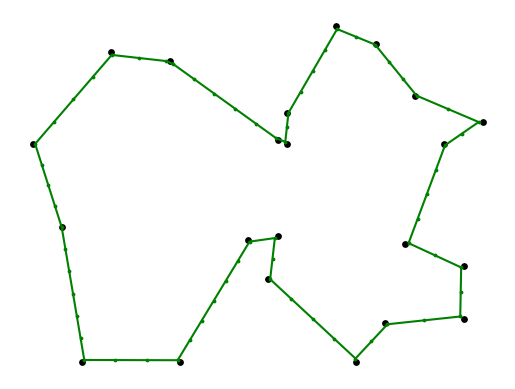

In [10]:
while elastic.iteration():
    num_iter = elastic._num_iter - 1
    if num_iter % 100 == 0:

        draw(cities, elastic._neurons)
        clear_output(wait=True)


draw(cities, elastic._neurons)